# EDA of the self driving dataset

---

Łukasz Borak 156043

## Loading and transforming the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cv2
import os
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image
import torch.nn as nn
import torch.optim as optim

In [2]:
filepaths = os.listdir('dataset')
filepaths

['1653043428.8546412.csv',
 '1652959186.4507334',
 '1653042695.4914637.csv',
 '1652875851.3497071',
 '1652959347.972946',
 '1653043202.5073502.csv',
 '1652959186.4507334.csv',
 '1652875901.3107166.csv',
 '1652876485.8123376.csv',
 '1652876206.2541456',
 '1653043549.5187616',
 '1653043202.5073502',
 '1653043345.3415065',
 '1653043345.3415065.csv',
 '1652876485.8123376',
 '1653042775.5213027',
 '1653042695.4914637',
 '1652959347.972946.csv',
 '1653043428.8546412',
 '1652875851.3497071.csv',
 '1652876013.741493.csv',
 '1653042775.5213027.csv',
 '1652876206.2541456.csv',
 '1652876013.741493',
 '1653043549.5187616.csv',
 '1652875901.3107166']

In [3]:
csv_filepaths = [path for path in filepaths if path.endswith('.csv')]
csv_filepaths

['1653043428.8546412.csv',
 '1653042695.4914637.csv',
 '1653043202.5073502.csv',
 '1652959186.4507334.csv',
 '1652875901.3107166.csv',
 '1652876485.8123376.csv',
 '1653043345.3415065.csv',
 '1652959347.972946.csv',
 '1652875851.3497071.csv',
 '1652876013.741493.csv',
 '1653042775.5213027.csv',
 '1652876206.2541456.csv',
 '1653043549.5187616.csv']

In [4]:
dataframes = []
for filepath in csv_filepaths:
    df = pd.read_csv(
        os.path.join('dataset', filepath),
        names = ['image_number', 'forward_signal', 'left_signal']
    )
    df.insert(0, 'image_path', filepath[:-4])
    df['image_path'] = df.apply(
        lambda x: x['image_path'] + '/' + ('000' + str(x['image_number']))[-4:] + '.jpg',
        axis=1,
    )
    print(df.head())
    print(df.columns)
    print(df.describe())
    print(df.info())
    dataframes.append(df)

                    image_path  image_number  forward_signal  left_signal
0  1653043428.8546412/0034.jpg            34        0.000000     0.039062
1  1653043428.8546412/0035.jpg            35        0.164062     0.000000
2  1653043428.8546412/0036.jpg            36        0.460938     0.000000
3  1653043428.8546412/0037.jpg            37        0.562500     0.000000
4  1653043428.8546412/0038.jpg            38        0.625000     0.000000
Index(['image_path', 'image_number', 'forward_signal', 'left_signal'], dtype='object')
       image_number  forward_signal  left_signal
count    670.000000      670.000000   670.000000
mean     368.500000        0.973064     0.214914
std      193.556624        0.080848     0.652831
min       34.000000        0.000000    -1.000000
25%      201.250000        1.000000     0.000000
50%      368.500000        1.000000     0.000000
75%      535.750000        1.000000     0.992188
max      703.000000        1.000000     0.992188
<class 'pandas.core.frame.Da

In [5]:
data = pd.concat(dataframes, axis=0)
data.head()

image_path  image_number  forward_signal  left_signal
0  1653043428.8546412/0034.jpg            34        0.000000     0.039062
1  1653043428.8546412/0035.jpg            35        0.164062     0.000000
2  1653043428.8546412/0036.jpg            36        0.460938     0.000000
3  1653043428.8546412/0037.jpg            37        0.562500     0.000000
4  1653043428.8546412/0038.jpg            38        0.625000     0.000000

### Let's see if we can read some images

1653043428.8546412/0034.jpg 0.0 0.0390625


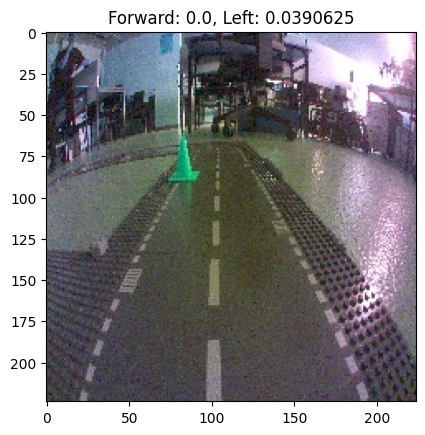

1653043428.8546412/0035.jpg 0.1640625 0.0


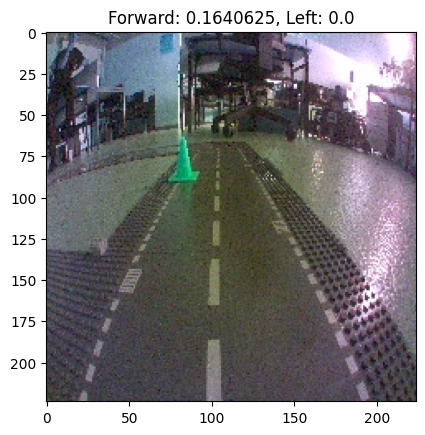

1653043428.8546412/0036.jpg 0.4609375 0.0


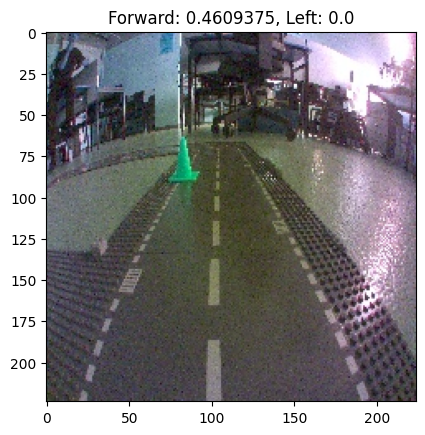

1653043428.8546412/0037.jpg 0.5625 0.0


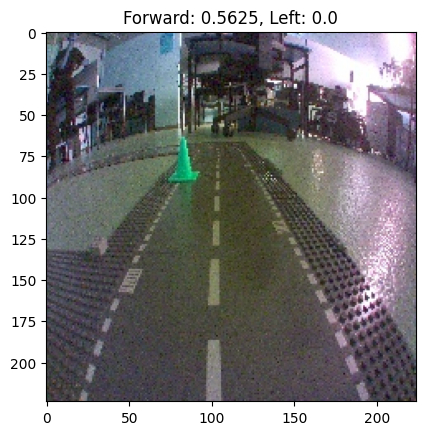

1653043428.8546412/0038.jpg 0.625 0.0


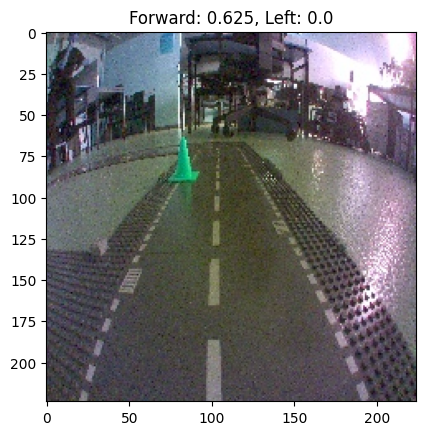

1653043428.8546412/0039.jpg 0.8671875 0.0


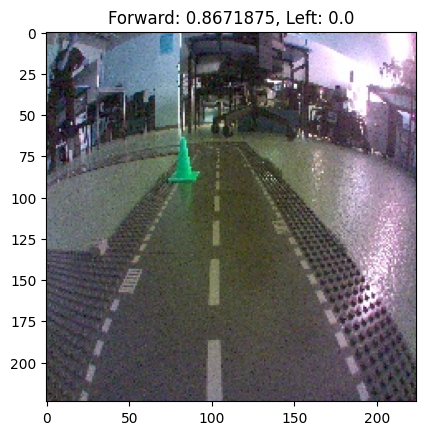

1653043428.8546412/0040.jpg 0.8671875 0.0


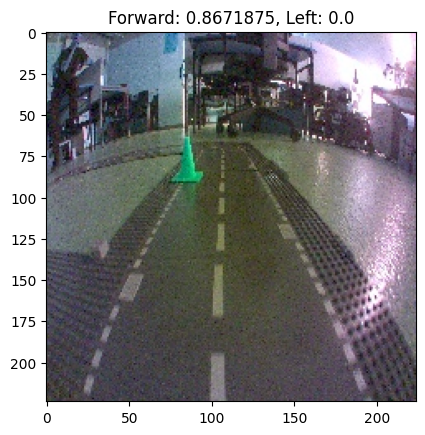

1653043428.8546412/0041.jpg 0.8671875 0.0


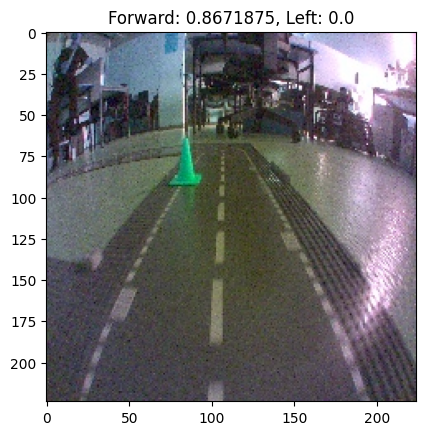

1653043428.8546412/0042.jpg 0.8671875 0.0


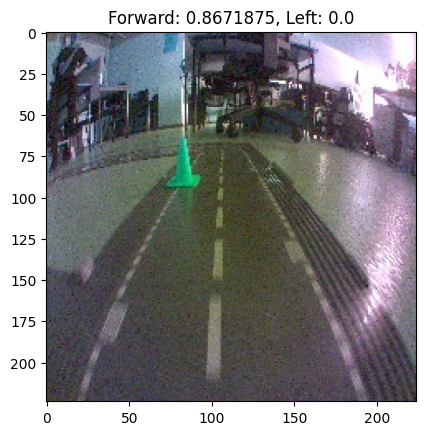

1653043428.8546412/0043.jpg 0.8671875 0.0


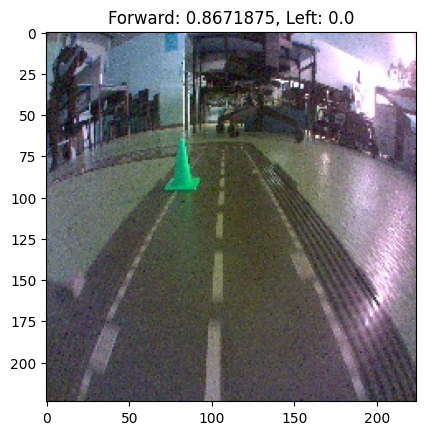

In [6]:
for i in range(10):
    image_path = data.iloc[i]['image_path']
    forward_signal = data.iloc[i]['forward_signal']
    left_signal = data.iloc[i]['left_signal']
    print(image_path, forward_signal, left_signal)
    image = cv2.imread(os.path.join('dataset', image_path))
    plt.imshow(image)
    plt.title(f'Forward: {forward_signal}, Left: {left_signal}')
    plt.show()

## Preprocessing pipeline

In [7]:
paths = data['image_path'].to_numpy()
fw = torch.tensor(
    data['forward_signal'].to_numpy(), 
    dtype=torch.float32
)
lt = torch.tensor(
    data['left_signal'].to_numpy(), 
    dtype=torch.float32
)

train_paths, val_paths, train_fw, val_fw, train_lt, val_lt = train_test_split(
    paths, fw, lt,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

In [8]:
add_noise = v2.Lambda(lambda img: img + torch.randn_like(img) * 0.02)

train_transforms = v2.Compose([
    v2.RandomResizedCrop(
        size=(224, 224),
        scale=(0.9, 1.0),
        ratio=(3/4, 4/3)
    ),
    v2.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.01
    ),
    v2.RandomPerspective(
        distortion_scale=0.1,
        p=0.5
    ),
    v2.RandomApply(
        transforms=[v2.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 2.0))],
        p=0.3
    ),
    v2.ToTensor(),
    v2.RandomErasing(
        p=0.5,
        scale=(0.02, 0.1),
        ratio=(0.3, 3.3),
    ),
    v2.RandomApply([add_noise], p=0.5),
])

val_transforms = v2.Compose([
    v2.ToTensor(),
])

/opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [9]:
class JetBotDataset(Dataset):
    def __init__(self, images, forward_signals, left_signals, transform=None):
        self.images = images
        self.forward_signals = forward_signals
        self.left_signals = left_signals
        self.transforms = transform

    
    def __len__(self):
        return len(self.images)

   
    def __getitem__(self, idx):
        image = Image.open(os.path.join('dataset', self.images[idx])).convert('RGB')
        image = self.transforms(image)
        forward_signal = self.forward_signals[idx]
        left_signal = self.left_signals[idx]
        label = torch.stack([forward_signal, left_signal], dim=0)
        return image, label


train_ds = JetBotDataset(
    train_paths,
    train_fw,
    train_lt,
    transform=train_transforms
)
val_ds = JetBotDataset(
    val_paths,
    val_fw,
    val_lt,
    transform=val_transforms
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

Length of dataset: 6067
Length of dataloader: 190
Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Forward signal shape: torch.Size([32])
Left signal shape: torch.Size([32])


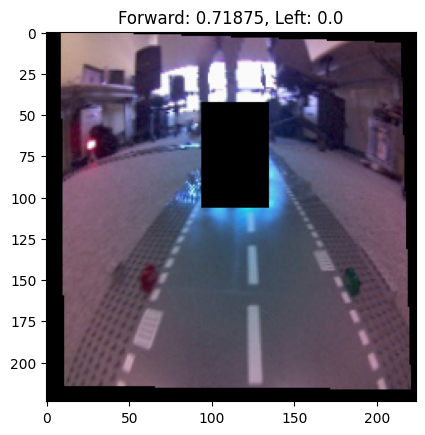

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08614555..1.017885].


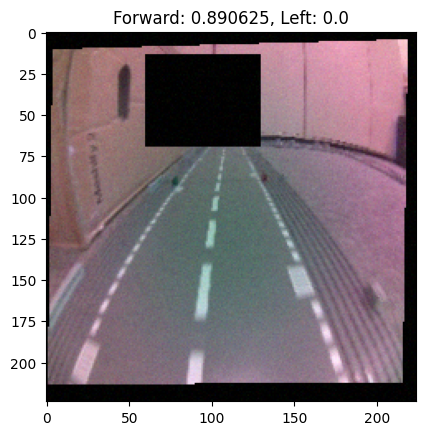

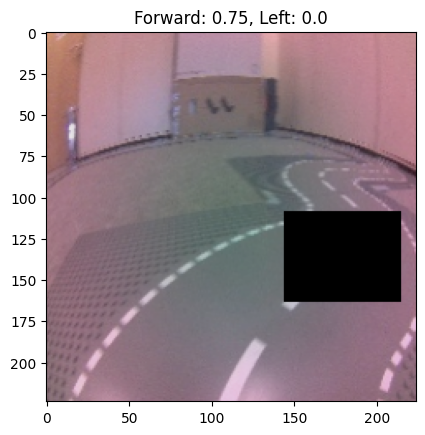

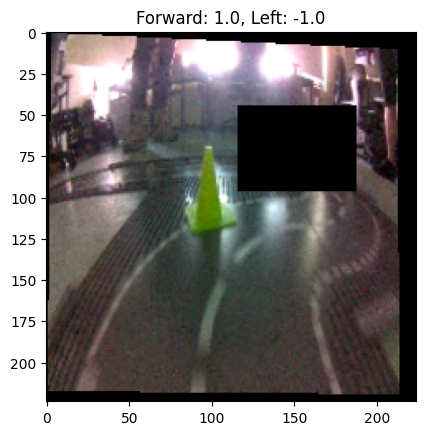

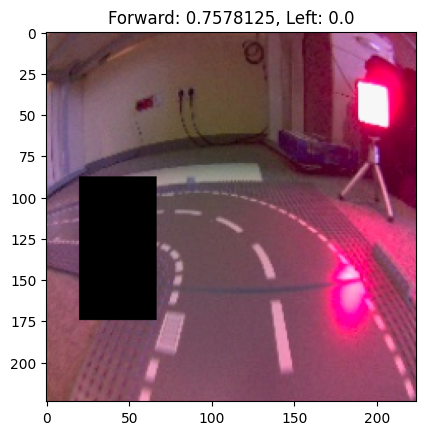

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0751906..0.8372913].


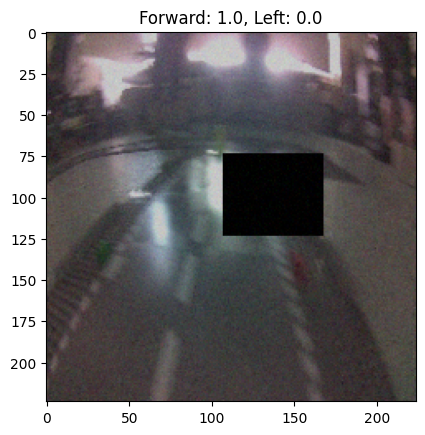

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.068429954..0.8805783].


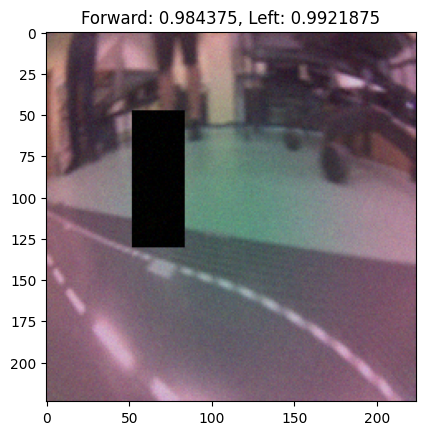

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07107369..1.0134159].


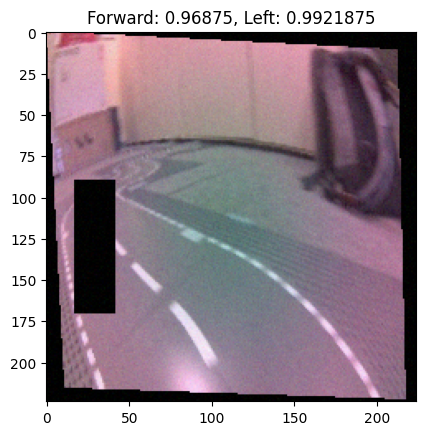

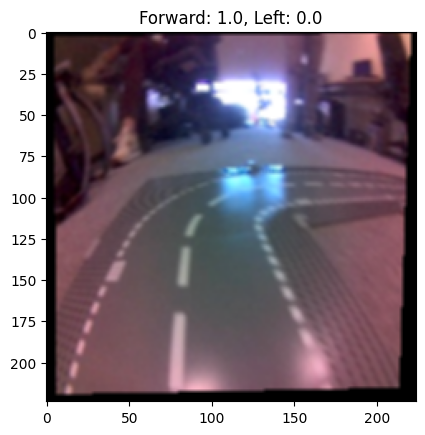

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07957032..0.9075812].


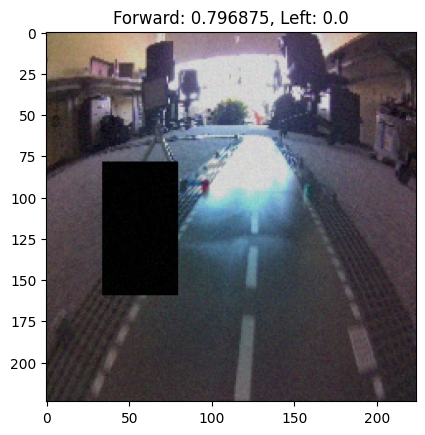

In [10]:
print(f'Length of dataset: {len(train_ds)}')
print(f'Length of dataloader: {len(train_loader)}')

for images, labels in train_loader:
    fwd_sig = labels[:, 0]
    left_sig = labels[:, 1]
    print(f'Batch size: {images.size(0)}')
    print(f'Image shape: {images.shape}')
    print(f'Forward signal shape: {fwd_sig.shape}')
    print(f'Left signal shape: {left_sig.shape}')
    break

for i in range(10):
    image, (forward_signal, left_signal) = train_ds[i]
    image = image.permute(1, 2, 0).numpy()
    plt.imshow(image)
    plt.title(f'Forward: {forward_signal}, Left: {left_signal}')
    plt.show()

Length of dataset: 1517
Length of dataloader: 48
Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Forward signal shape: torch.Size([32])
Left signal shape: torch.Size([32])


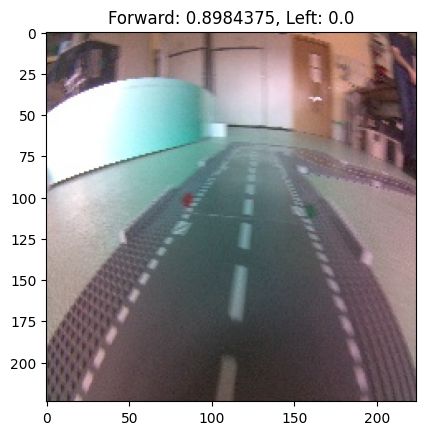

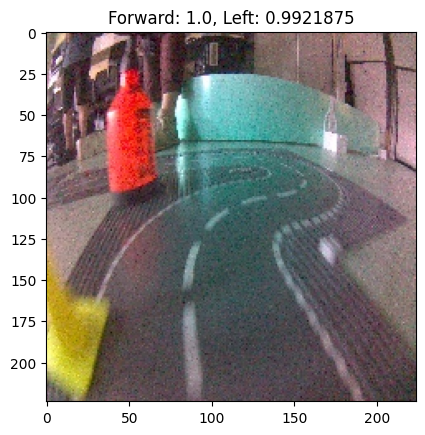

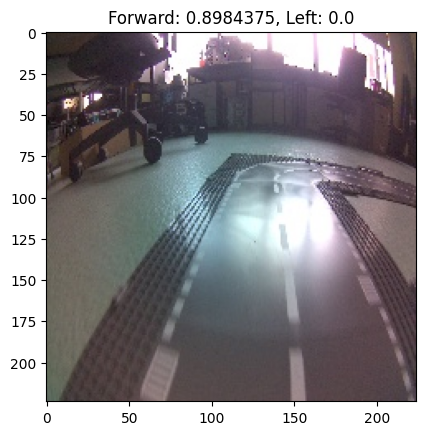

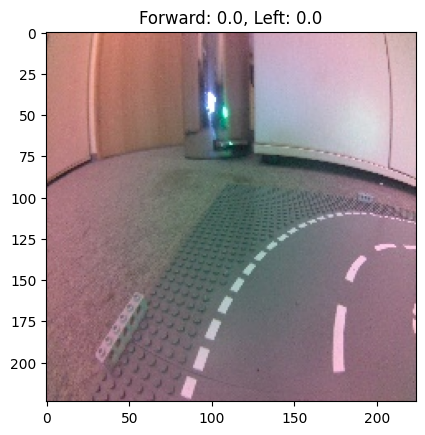

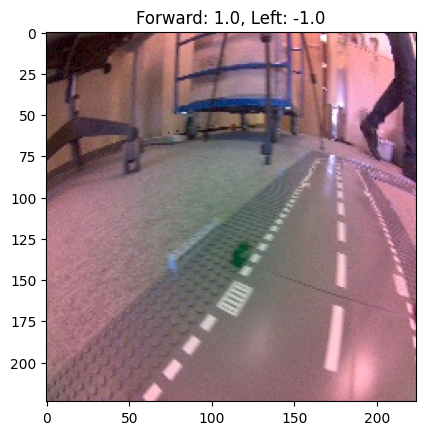

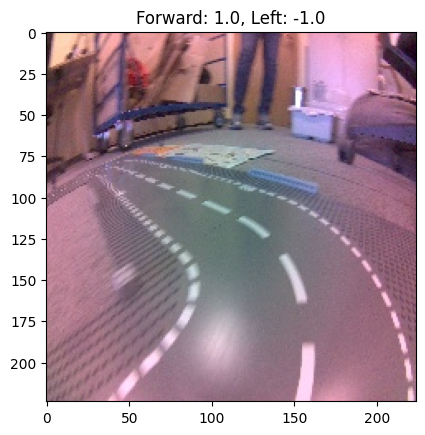

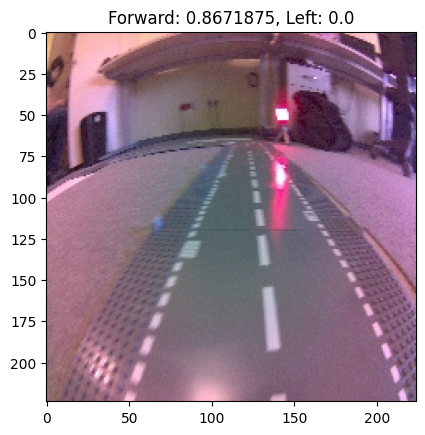

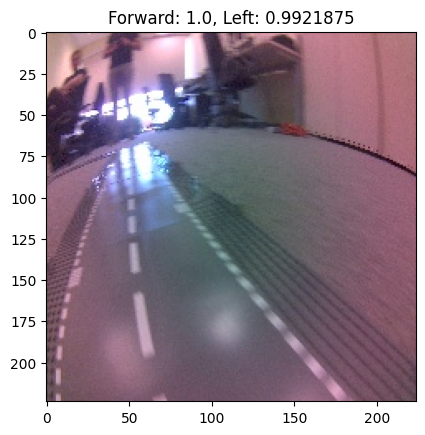

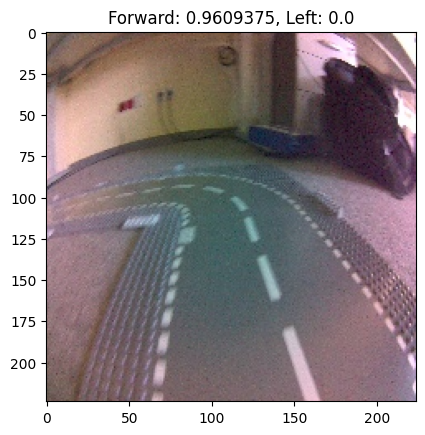

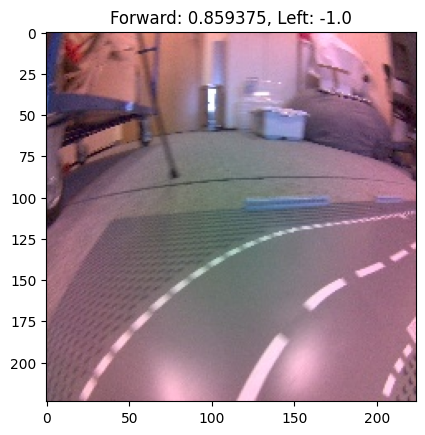

In [11]:
print(f'Length of dataset: {len(val_ds)}')
print(f'Length of dataloader: {len(val_loader)}')

for images, labels in val_loader:
    fwd_sig = labels[:, 0]
    left_sig = labels[:, 1]
    print(f'Batch size: {images.size(0)}')
    print(f'Image shape: {images.shape}')
    print(f'Forward signal shape: {fwd_sig.shape}')
    print(f'Left signal shape: {left_sig.shape}')
    break

for i in range(10):
    image, (forward_signal, left_signal) = val_ds[i]
    image = image.permute(1, 2, 0).numpy()
    plt.imshow(image)
    plt.title(f'Forward: {forward_signal}, Left: {left_signal}')
    plt.show()

## Model experimentation

The goal is to build a CNN-based model that outputs predictions for 2 continuous values - forward and left.

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self, num_outputs=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool  = nn.MaxPool2d(2)
        self.relu  = nn.ReLU()

        self.fc1   = nn.Linear(32*56*56, 128)
        self.fc2   = nn.Linear(128, num_outputs)

        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)    # [batch, 2]
    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_outputs=2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)   # labels: [B,2]

        optimizer.zero_grad()
        outputs = model(images)        # [B,2]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    avg_train_loss = total_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item() * images.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} — "
          f"Train MSE: {avg_train_loss:.4f}, "
          f"Val MSE:   {avg_val_loss:.4f}")

Epoch 1/2 — Train MSE: 0.6412, Val MSE:   0.1668
Epoch 2/2 — Train MSE: 0.1632, Val MSE:   0.1172


## Saving the model and exporting to ONNX

In [14]:
example_inputs = (torch.randn(1, 3, 224, 224),)
onnx_program = torch.onnx.export(model, example_inputs, dynamo=True)
onnx_program.optimize()
onnx_program.save("test.onnx")

[torch.onnx] Obtain model graph for `SimpleCNN([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `SimpleCNN([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
